# Исследовательский проект: рекомендация тарифов оператора мобильной  связи "Мегалайн"

# Описание проекта:

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже была сделана.

Следует построить модель с максимально большим значением *accuracy*. Чтобы проект считался успешно сданным, нужно довести долю правильных ответов по крайней мере до 0.75. Проверка *accuracy* на тестовой выборке проходит самостоятельно.

# Описание данных:

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

   `сalls` — количество звонков;

   `minutes` — суммарная длительность звонков в минутах;

   `messages` — количество sms-сообщений;

   `mb_used` — израсходованный интернет-трафик в Мб;

   `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0);

## Откроем и изучим файл

In [1]:
from tqdm import tqdm
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    print('Проверьте корретность к пути файлу или наличие самого файла в каталоге!')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
for x in df.columns:
    print("Кол-во дубликтов для столбца", x, "равняется", df[x].duplicated().sum())

Кол-во дубликтов для столбца calls равняется 3030
Кол-во дубликтов для столбца minutes равняется 70
Кол-во дубликтов для столбца messages равняется 3034
Кол-во дубликтов для столбца mb_used равняется 11
Кол-во дубликтов для столбца is_ultra равняется 3212


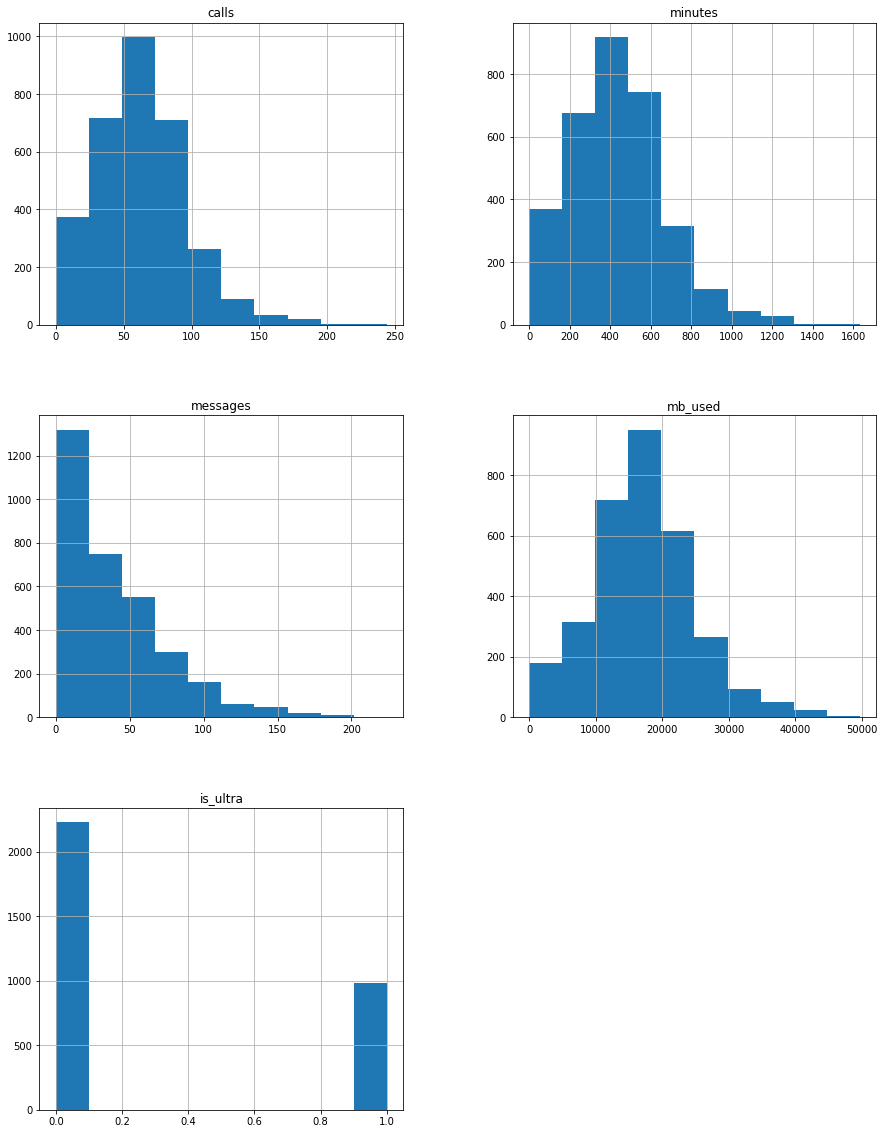

In [7]:
df.hist(figsize=(15,20))
plt.show()

In [8]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


**Промежуточные выводы:**

1. Увидели, что тех кто пользуется тарифом "Смарт" чуть больше в два раза, чем тех клиентов, которые пользуются тарифом "Ультра"
2. Понимаем, что единственная категориальная переменная для нас в датасете - это 'is_ultra'
3. Отсутсвуют пропуски и присутствуют во всех столбцах явные дубликаты
4. Типы переменных в столбцах у нас - числовые
5. Значения столбцов 'calls', 'minutes', 'mb_used' - более близки к нормальному распределению, в отличии от 'is_ultra' и 'messages'

## Разобьем данные на выборки

    Необходимо разбить датасет на тренировочную, валидационную и тестовую выборку, для того чтобы проверить есть ли у модели  
    переобучение или недообучение. 

    Алгоритм и включенные в него методы на которых, благодаря чему возможны предсказания значений - и будет для нас   
    представляться как пригодная модель.

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra'] 

Следует использовать соотношение 3:1:1, которая выражается как:

     1. Обучающая (train 60% выборки);
     2. Валидационная (valid 20% выборки);
     3. Тестовая (test 20% выборки );

In [22]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                      train_size=0.6, 
                                                                                      random_state=42,
                                                                                      stratify=target)

In [23]:
features_test, features_validate, target_test, target_validate = train_test_split(features_test, target_test, 
                                                                                      train_size=0.5, 
                                                                                      random_state=42,
                                                                                      stratify=target_test)

In [24]:
df['is_ultra'].sum()

985

In [25]:
target_train.sum() 

591

In [26]:
target_test.sum() 

197

In [27]:
target_validate.sum() 

197

## Построим модели

    Понимаем, что для Категориальных данных применимы лишь определенные методы предсказания, и в нашем случае у нас бинарная  
    классификация для целевого признака (таргета) - 0 или 1

    Рассмотрим две различные модели: Решающее дерево и Случайный леc

    Для каждого из них изменим в циклах два количественных гиперпараметра, и один выбранный критерий отдельно, - после можем 
    выбрать для себя лучшие гиперпараметры на основании accuracy_score, более приближеннной к 1

**Решающее дерево на валидационной выборке:**

In [28]:
%%time 
max_depth = None
min_samples_split = None
best_result = 0
best_depth = 0
best_msp = 0
for depth in range(1, 6):
    for msp in tqdm(range(2, 7)): # tqdm будет показывать время выполнения когда проходимся по циклу
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion='gini', min_samples_split=msp) # инициализируем модель DecisionTreeClassifier с параметрами проходящими по циклу
        model = model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_validate) # получим предсказания модели на валидационной выборке
        print("min_samples_split=", msp, "     max_depth =", depth, "    accuracy_score: ", end='')
        result = accuracy_score(target_validate, predictions_valid) # посчитаем значение метрики  accuracy_score на валидационной выборке
        print(accuracy_score(target_validate, predictions_valid))
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_msp = msp
            
print()
print("Наилучшая модель на валидационной выборке:", best_result, "Глубина дерева:", best_depth, "Минимальное число разделений:", best_msp)
print("Использовался критерий 'gini'")
# %%time измерит в конце время ожидания и выполнения 

100%|██████████| 5/5 [00:00<00:00, 213.47it/s]


min_samples_split= 2      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 3      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 4      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 5      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 6      max_depth = 1     accuracy_score: 0.749611197511664


100%|██████████| 5/5 [00:00<00:00, 192.28it/s]


min_samples_split= 2      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 3      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 4      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 5      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 6      max_depth = 2     accuracy_score: 0.7744945567651633


100%|██████████| 5/5 [00:00<00:00, 85.78it/s]


min_samples_split= 2      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 3      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 4      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 5      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 6      max_depth = 3     accuracy_score: 0.7838258164852255


100%|██████████| 5/5 [00:00<00:00, 149.86it/s]


min_samples_split= 2      max_depth = 4     accuracy_score: 0.7900466562986003
min_samples_split= 3      max_depth = 4     accuracy_score: 0.7900466562986003
min_samples_split= 4      max_depth = 4     accuracy_score: 0.7900466562986003
min_samples_split= 5      max_depth = 4     accuracy_score: 0.7900466562986003
min_samples_split= 6      max_depth = 4     accuracy_score: 0.7900466562986003


100%|██████████| 5/5 [00:00<00:00, 96.57it/s]

min_samples_split= 2      max_depth = 5     accuracy_score: 0.7931570762052877
min_samples_split= 3      max_depth = 5     accuracy_score: 0.7931570762052877
min_samples_split= 4      max_depth = 5     accuracy_score: 0.7931570762052877
min_samples_split= 5      max_depth = 5     accuracy_score: 0.7931570762052877
min_samples_split= 6      max_depth = 5     accuracy_score: 0.7931570762052877

Наилучшая модель на валидационной выборке: 0.7931570762052877 Глубина дерева: 5 Минимальное число разделений: 2
Использовался критерий 'gini'
CPU times: user 161 ms, sys: 16.6 ms, total: 178 ms
Wall time: 203 ms


[Text(1698.2608695652173, 1793.88, 'X[3] <= 26262.681\ngini = 0.425\nsamples = 1928\nvalue = [1337, 591]'),
 Text(970.4347826086956, 1467.72, 'X[1] <= 728.425\ngini = 0.379\nsamples = 1739\nvalue = [1298, 441]'),
 Text(485.2173913043478, 1141.56, 'X[2] <= 117.5\ngini = 0.329\nsamples = 1579\nvalue = [1251, 328]'),
 Text(242.6086956521739, 815.3999999999999, 'X[3] <= 11179.0\ngini = 0.313\nsamples = 1549\nvalue = [1248, 301]'),
 Text(121.30434782608695, 489.24, 'X[3] <= 632.39\ngini = 0.452\nsamples = 359\nvalue = [235, 124]'),
 Text(60.65217391304348, 163.07999999999993, 'gini = 0.133\nsamples = 14\nvalue = [1, 13]'),
 Text(181.95652173913044, 163.07999999999993, 'gini = 0.436\nsamples = 345\nvalue = [234, 111]'),
 Text(363.9130434782609, 489.24, 'X[0] <= 0.5\ngini = 0.253\nsamples = 1190\nvalue = [1013, 177]'),
 Text(303.2608695652174, 163.07999999999993, 'gini = 0.278\nsamples = 18\nvalue = [3, 15]'),
 Text(424.5652173913043, 163.07999999999993, 'gini = 0.238\nsamples = 1172\nvalue =

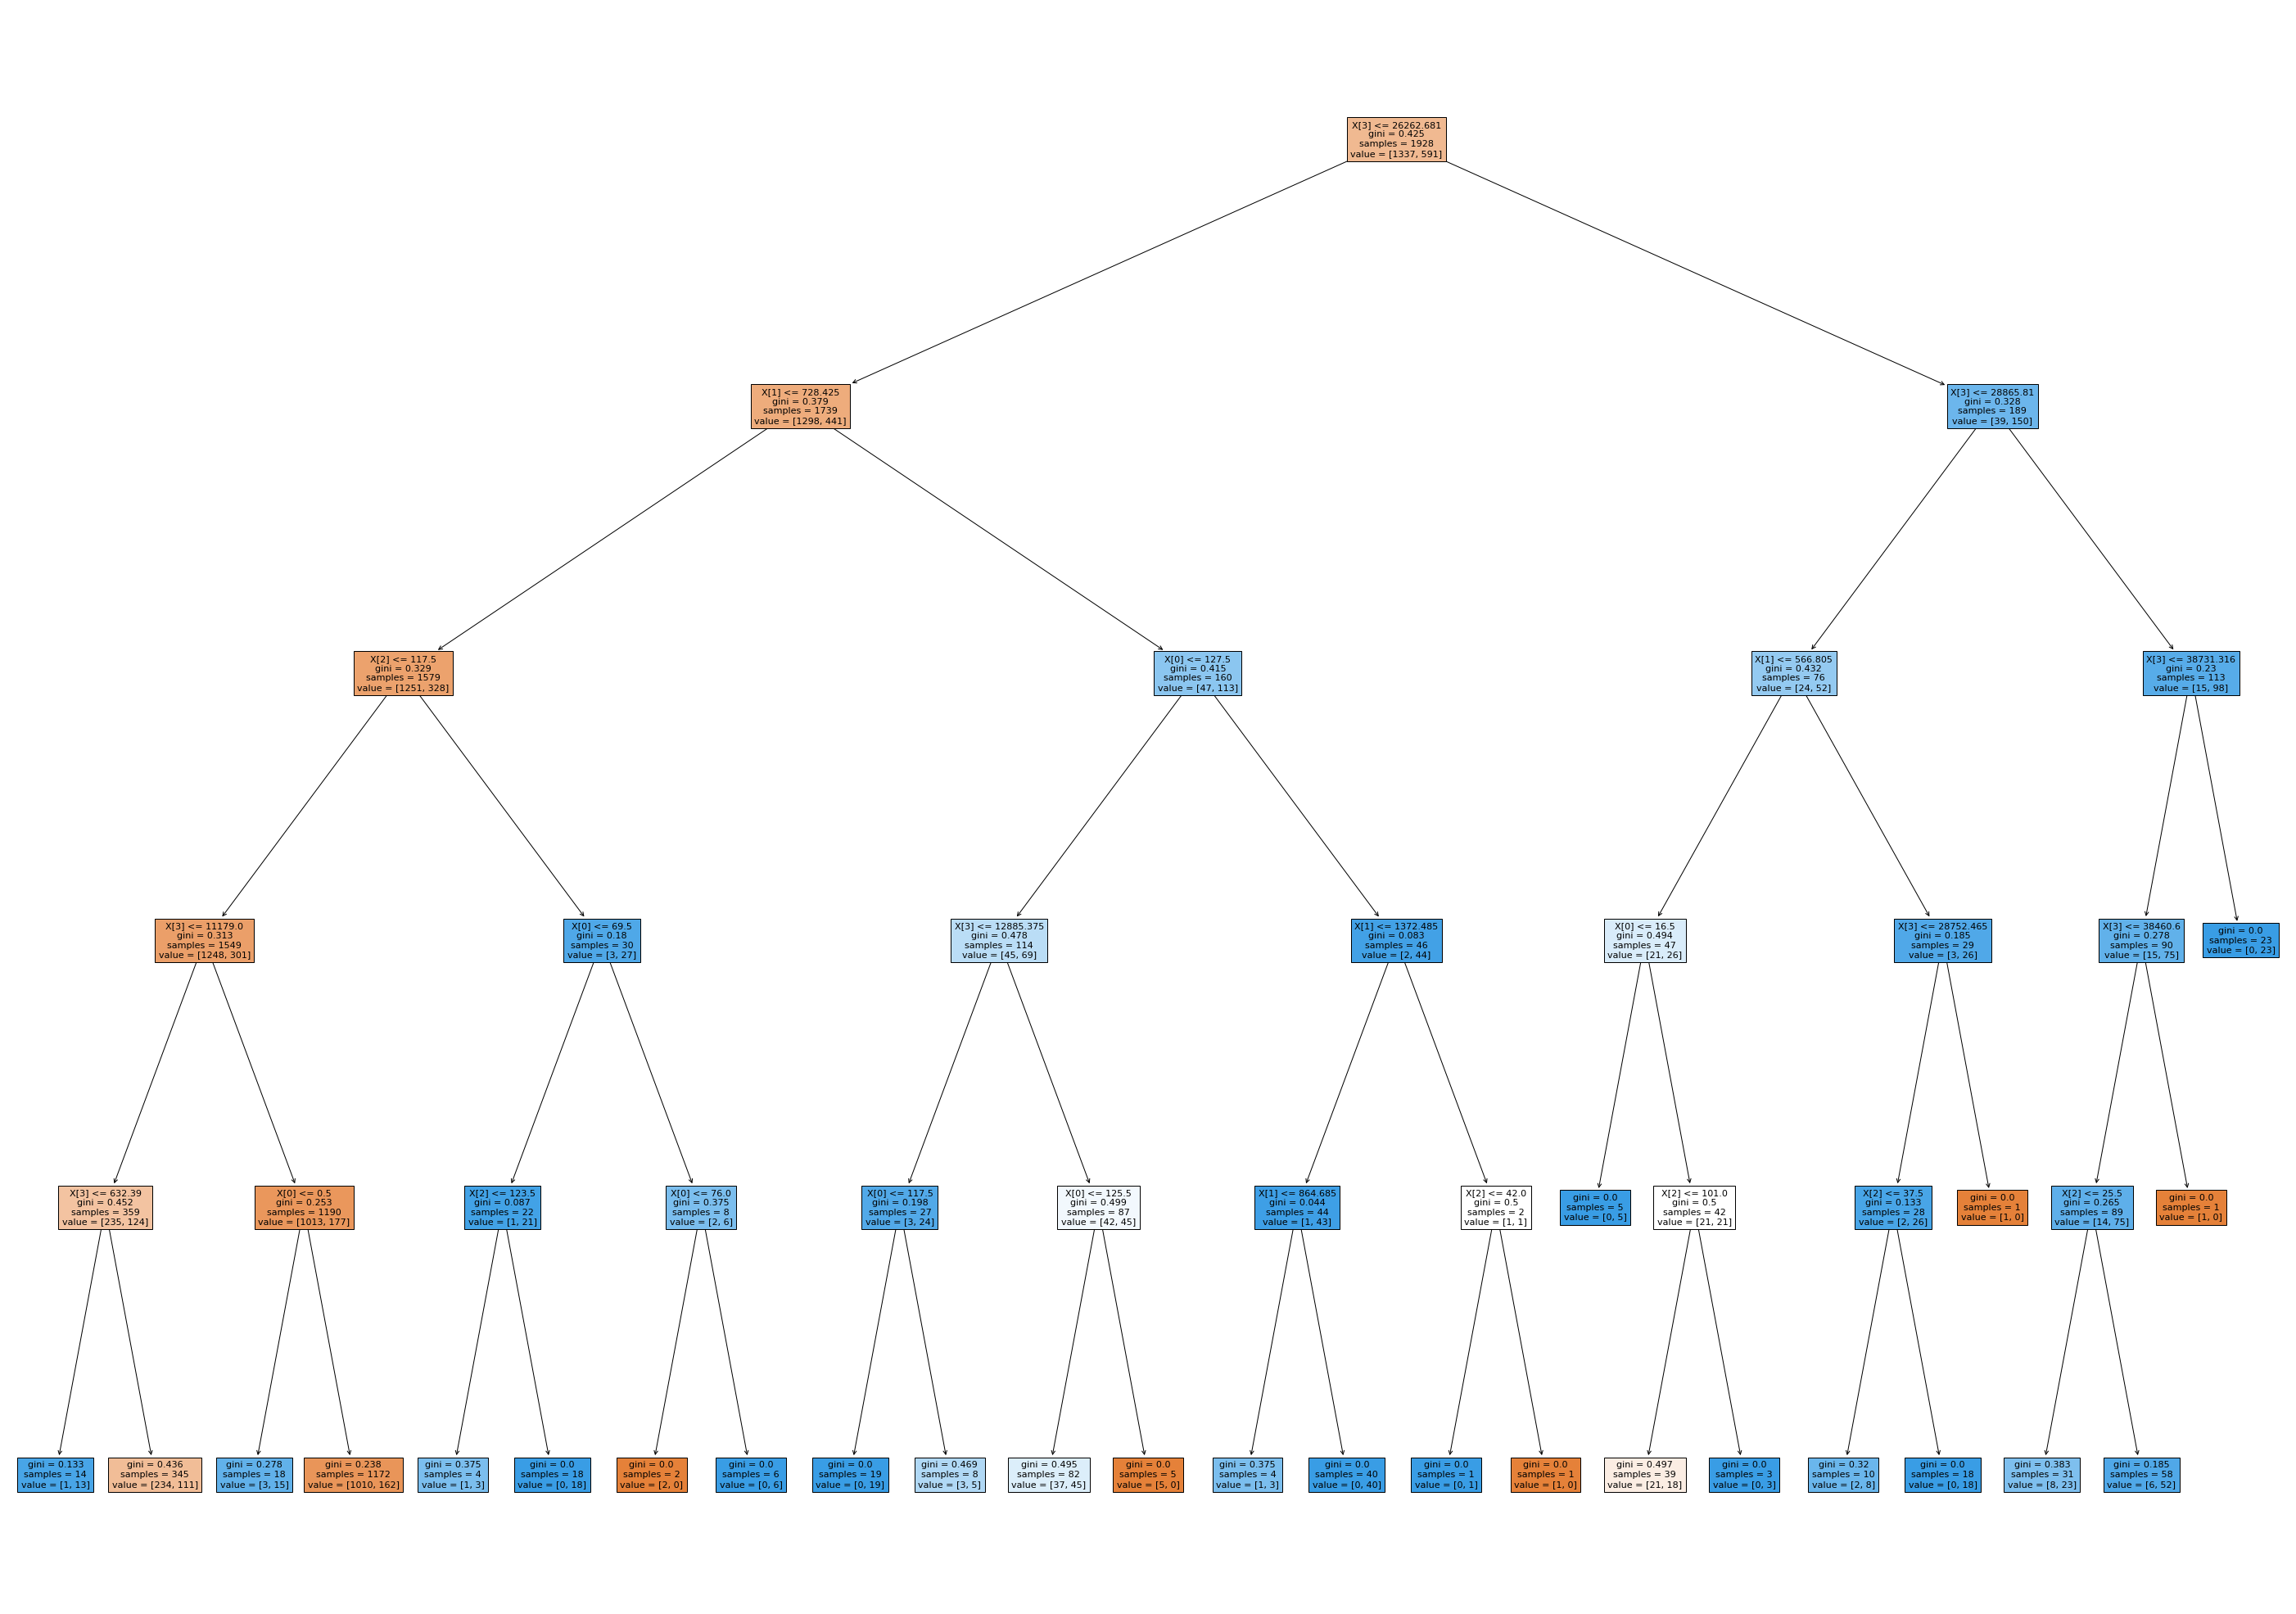

In [29]:
plt.figure(figsize=(50,36))
tree.plot_tree(best_model, filled=True) 

In [30]:
%%time 
max_depth = None
min_samples_split = None
best_result = 0
best_depth = 0
best_msp = 0
for depth in range(1, 6):
    for msp in tqdm(range(2, 7)): # tqdm будет показывать время выполнения когда проходимся по циклу
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth,  criterion="entropy", min_samples_split=msp) # инициализируем модель DecisionTreeClassifier с параметрами проходящими по цикл
        model = model.fit(features_train, target_train)  # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_validate) # получим предсказания модели на валидационной выборке
        print("min_samples_split=", msp, "     max_depth =", depth, "    accuracy_score: ", end='')
        result = accuracy_score(target_validate, predictions_valid) # посчитаем значение метрики  accuracy_score на валидационной выборке
        print(accuracy_score(target_validate, predictions_valid))
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_msp = msp
            
    
print()
print("Наилучшая модель на валидационной выборке:", best_result, "Глубина дерева:", best_depth, "Минимальное число разделений:", best_msp)
print("Использовался критерий 'entropy'")
# %%time измерит в конце время ожидания и выполнения 

100%|██████████| 5/5 [00:00<00:00, 175.23it/s]


min_samples_split= 2      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 3      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 4      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 5      max_depth = 1     accuracy_score: 0.749611197511664
min_samples_split= 6      max_depth = 1     accuracy_score: 0.749611197511664


100%|██████████| 5/5 [00:00<00:00, 153.22it/s]


min_samples_split= 2      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 3      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 4      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 5      max_depth = 2     accuracy_score: 0.7744945567651633
min_samples_split= 6      max_depth = 2     accuracy_score: 0.7744945567651633


100%|██████████| 5/5 [00:00<00:00, 94.99it/s]


min_samples_split= 2      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 3      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 4      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 5      max_depth = 3     accuracy_score: 0.7838258164852255
min_samples_split= 6      max_depth = 3     accuracy_score: 0.7838258164852255


100%|██████████| 5/5 [00:00<00:00, 127.08it/s]


min_samples_split= 2      max_depth = 4     accuracy_score: 0.7838258164852255
min_samples_split= 3      max_depth = 4     accuracy_score: 0.7838258164852255
min_samples_split= 4      max_depth = 4     accuracy_score: 0.7838258164852255
min_samples_split= 5      max_depth = 4     accuracy_score: 0.7838258164852255
min_samples_split= 6      max_depth = 4     accuracy_score: 0.7838258164852255


  0%|          | 0/5 [00:00<?, ?it/s]

min_samples_split= 2      max_depth = 5     accuracy_score: 0.7869362363919129
min_samples_split= 3      max_depth = 5     accuracy_score: 0.7869362363919129
min_samples_split= 4      max_depth = 5     accuracy_score: 0.7869362363919129
min_samples_split= 5      max_depth = 5     accuracy_score: 

100%|██████████| 5/5 [00:00<00:00, 87.32it/s]

0.7869362363919129
min_samples_split= 6      max_depth = 5     accuracy_score: 0.7869362363919129

Наилучшая модель на валидационной выборке: 0.7869362363919129 Глубина дерева: 5 Минимальное число разделений: 2
Использовался критерий 'entropy'
CPU times: user 197 ms, sys: 12.8 ms, total: 210 ms
Wall time: 222 ms


**Случайный лес на валидационной выборке:**

In [31]:
%%time 
n_estimators = None
min_samples_leaf = None
best_result = 0
best_estimators = 0
best_msl = 0
for estimators in tqdm(range(100, 106)): # tqdm будет показывать время выполнения когда проходимся по циклу
    for msl in range(1, 6):
        model = RandomForestClassifier(random_state=12345, n_estimators=estimators, criterion="gini", min_samples_leaf=msl) # инициализируем модель RandomForestClassifier с параметрами проходящими по циклу
        model = model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_validate) # получим предсказания модели на валидационной выборке
        print("min_samples_leaf=", msl, "    n_estimators =", estimators, "    accuracy_score: ", end='')
        result = accuracy_score(target_validate, predictions_valid) # посчитаем значение метрики  accuracy_score на валидационной выборке
        print(accuracy_score(target_validate, predictions_valid))
        if result > best_result:
            best_model = model
            best_result = result
            best_estimators = estimators
            best_msl = msl
            
        
print()
print("Наилучшая модель на валидационной выборке:", best_result, "Оценки:", estimators, "Минимальное число листов:", best_msl)
print("Использовался критерий 'gini'")
# %%time измерит в конце время ожидания и выполнения 

  0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf= 1     n_estimators = 100     accuracy_score: 0.7962674961119751
min_samples_leaf= 2     n_estimators = 100     accuracy_score: 0.7962674961119751
min_samples_leaf= 3     n_estimators = 100     accuracy_score: 0.807153965785381
min_samples_leaf= 4     n_estimators = 100     accuracy_score: 0.8009331259720062


 17%|█▋        | 1/6 [00:02<00:10,  2.07s/it]

min_samples_leaf= 5     n_estimators = 100     accuracy_score: 0.8102643856920684
min_samples_leaf= 1     n_estimators = 101     accuracy_score: 0.7978227060653188
min_samples_leaf= 2     n_estimators = 101     accuracy_score: 0.7978227060653188
min_samples_leaf= 3     n_estimators = 101     accuracy_score: 0.807153965785381
min_samples_leaf= 4     n_estimators = 101     accuracy_score: 0.8009331259720062


 33%|███▎      | 2/6 [00:05<00:10,  2.60s/it]

min_samples_leaf= 5     n_estimators = 101     accuracy_score: 0.8055987558320373
min_samples_leaf= 1     n_estimators = 102     accuracy_score: 0.7962674961119751
min_samples_leaf= 2     n_estimators = 102     accuracy_score: 0.7962674961119751
min_samples_leaf= 3     n_estimators = 102     accuracy_score: 0.807153965785381
min_samples_leaf= 4     n_estimators = 102     accuracy_score: 0.80248833592535


 50%|█████     | 3/6 [00:07<00:07,  2.36s/it]

min_samples_leaf= 5     n_estimators = 102     accuracy_score: 0.807153965785381
min_samples_leaf= 1     n_estimators = 103     accuracy_score: 0.7962674961119751
min_samples_leaf= 2     n_estimators = 103     accuracy_score: 0.7978227060653188
min_samples_leaf= 3     n_estimators = 103     accuracy_score: 0.807153965785381
min_samples_leaf= 4     n_estimators = 103     accuracy_score: 0.80248833592535


 67%|██████▋   | 4/6 [00:09<00:04,  2.24s/it]

min_samples_leaf= 5     n_estimators = 103     accuracy_score: 0.8055987558320373
min_samples_leaf= 1     n_estimators = 104     accuracy_score: 0.7962674961119751
min_samples_leaf= 2     n_estimators = 104     accuracy_score: 0.7978227060653188
min_samples_leaf= 3     n_estimators = 104     accuracy_score: 0.8055987558320373
min_samples_leaf= 4     n_estimators = 104     accuracy_score: 0.80248833592535


 83%|████████▎ | 5/6 [00:11<00:02,  2.21s/it]

min_samples_leaf= 5     n_estimators = 104     accuracy_score: 0.8055987558320373
min_samples_leaf= 1     n_estimators = 105     accuracy_score: 0.7978227060653188
min_samples_leaf= 2     n_estimators = 105     accuracy_score: 0.7962674961119751
min_samples_leaf= 3     n_estimators = 105     accuracy_score: 0.807153965785381
min_samples_leaf= 4     n_estimators = 105     accuracy_score: 0.8009331259720062


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]

min_samples_leaf= 5     n_estimators = 105     accuracy_score: 0.8055987558320373

Наилучшая модель на валидационной выборке: 0.8102643856920684 Оценки: 105 Минимальное число листов: 5
Использовался критерий 'gini'
CPU times: user 12.4 s, sys: 135 ms, total: 12.5 s
Wall time: 13.5 s


In [32]:
%%time 
n_estimators = None
min_samples_leaf = None
best_result = 0
best_estimators = 0
best_msl = 0
for estimators in tqdm(range(100, 106)): # tqdm будет показывать время выполнения когда проходимся по циклу
    for msl in range(1, 6):
        model = RandomForestClassifier(random_state=12345, n_estimators=estimators, criterion="entropy", min_samples_leaf=msl) # инициализируем модель RandomForestClassifier с параметрами проходящими по циклу
        model = model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_validate)  # получим предсказания модели на валидационной выборке
        print("min_samples_leaf=", msl,"    n_estimators =", estimators, "    accuracy_score: ", end='')
        result = accuracy_score(target_validate, predictions_valid)  # посчитаем значение метрики  accuracy_score на валидационной выборке
        print(accuracy_score(target_validate, predictions_valid))
        if result > best_result:
            best_model = model
            best_result = result
            best_estimators = estimators
            best_msl = msl
        
print()
print("Наилучшая модель на валидационной выборке:", best_result, "Оценки:", best_estimators, "Минимальное число листов:", best_msl)
print("Использовался критерий 'entropy'")
# %%time измерит в конце время ожидания и выполнения 

  0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf= 1     n_estimators = 100     accuracy_score: 0.7962674961119751
min_samples_leaf= 2     n_estimators = 100     accuracy_score: 0.8087091757387247
min_samples_leaf= 3     n_estimators = 100     accuracy_score: 0.8040435458786936
min_samples_leaf= 4     n_estimators = 100     accuracy_score: 0.8118195956454122


 17%|█▋        | 1/6 [00:02<00:12,  2.43s/it]

min_samples_leaf= 5     n_estimators = 100     accuracy_score: 0.8055987558320373
min_samples_leaf= 1     n_estimators = 101     accuracy_score: 0.7947122861586314
min_samples_leaf= 2     n_estimators = 101     accuracy_score: 0.807153965785381
min_samples_leaf= 3     n_estimators = 101     accuracy_score: 0.7993779160186625
min_samples_leaf= 4     n_estimators = 101     accuracy_score: 0.8133748055987559


 33%|███▎      | 2/6 [00:04<00:09,  2.36s/it]

min_samples_leaf= 5     n_estimators = 101     accuracy_score: 0.8055987558320373
min_samples_leaf= 1     n_estimators = 102     accuracy_score: 0.7931570762052877
min_samples_leaf= 2     n_estimators = 102     accuracy_score: 0.807153965785381
min_samples_leaf= 3     n_estimators = 102     accuracy_score: 0.8040435458786936
min_samples_leaf= 4     n_estimators = 102     accuracy_score: 0.8133748055987559


 50%|█████     | 3/6 [00:07<00:07,  2.38s/it]

min_samples_leaf= 5     n_estimators = 102     accuracy_score: 0.8040435458786936
min_samples_leaf= 1     n_estimators = 103     accuracy_score: 0.7947122861586314
min_samples_leaf= 2     n_estimators = 103     accuracy_score: 0.807153965785381
min_samples_leaf= 3     n_estimators = 103     accuracy_score: 0.8040435458786936
min_samples_leaf= 4     n_estimators = 103     accuracy_score: 0.8118195956454122


 67%|██████▋   | 4/6 [00:09<00:04,  2.37s/it]

min_samples_leaf= 5     n_estimators = 103     accuracy_score: 0.8040435458786936
min_samples_leaf= 1     n_estimators = 104     accuracy_score: 0.7947122861586314
min_samples_leaf= 2     n_estimators = 104     accuracy_score: 0.807153965785381
min_samples_leaf= 3     n_estimators = 104     accuracy_score: 0.80248833592535
min_samples_leaf= 4     n_estimators = 104     accuracy_score: 0.8149300155520995


 83%|████████▎ | 5/6 [00:11<00:02,  2.40s/it]

min_samples_leaf= 5     n_estimators = 104     accuracy_score: 0.8040435458786936
min_samples_leaf= 1     n_estimators = 105     accuracy_score: 0.7947122861586314
min_samples_leaf= 2     n_estimators = 105     accuracy_score: 0.8055987558320373
min_samples_leaf= 3     n_estimators = 105     accuracy_score: 0.80248833592535
min_samples_leaf= 4     n_estimators = 105     accuracy_score: 0.8118195956454122


100%|██████████| 6/6 [00:15<00:00,  2.57s/it]

min_samples_leaf= 5     n_estimators = 105     accuracy_score: 0.8055987558320373

Наилучшая модель на валидационной выборке: 0.8149300155520995 Оценки: 104 Минимальное число листов: 4
Использовался критерий 'entropy'
CPU times: user 14.1 s, sys: 154 ms, total: 14.3 s
Wall time: 15.4 s


**Промежуточные выводы по исследованию:**

**В ходе исследования удалось достичь accuracy не меньше 0.75 в обоих моделях предсказания на валидационной выборке**
    
**Лучшие гиперпараметры для модели Случайный лес (accuracy_score: 0.8149300155520995):**

     Оценки: 104            Минимальное число листов: 4    критерий 'entropy'
    
**Лучшие гиперпараметры для модели  Решающее дерево (accuracy_score: 0.7931570762052877):**

     Глубина дерева: 5     Минимальное число разделений: 2   критерий 'gini'

In [33]:
%%time  

model_gs = RandomForestClassifier(random_state=12345, criterion="entropy")

parametrs_gs  = {
    "n_estimators": [100, 101, 102, 103, 104, 105, 106],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
}


gs = GridSearchCV(estimator = model_gs,
                  param_grid = parametrs_gs,
                  cv=5)

gs.fit(features_train, target_train)

# Wall time: 1min 36s : 2min 01s

CPU times: user 1min 32s, sys: 720 ms, total: 1min 33s
Wall time: 1min 45s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=12345),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 101, 102, 103, 104, 105, 106]})

In [34]:
print(gs.best_estimator_)
print(gs.best_score_)

RandomForestClassifier(criterion='entropy', min_samples_leaf=5,
                       n_estimators=104, random_state=12345)
0.8023739990579368


## Проверим модель на тестовой выборке

**Из моделей выбирем Случанный лес для тестовой выборке как наилучшую модель со следующими гиперпараметрами:**

       1. random_state=12345
       2. n_estimators=100 
       3. criterion="entropy"
       4. min_samples_leaf=4

In [35]:
model_test = RandomForestClassifier(random_state=12345, n_estimators=100, criterion="entropy", min_samples_leaf=4)

In [36]:
model_test = model_test.fit(pd.concat([features_train, features_validate]), pd.concat([target_train, target_validate]))

In [37]:
print(len(pd.concat([features_train, features_validate])) / len(df)) # 0.59... + 0.20...

0.7999377722464219


In [38]:
predictions_test = model_test.predict(features_test)

In [39]:
result_test = accuracy_score(target_test, predictions_test)
print("Наилучшая модель на Тестовой выборке получилась c accuracy_score равной",    result_test)
print("Наилучшая модель на Валидационной выборке была  c accuracy_score равной 0.8133748055987559")

Наилучшая модель на Тестовой выборке получилась c accuracy_score равной 0.8055987558320373
Наилучшая модель на Валидационной выборке была  c accuracy_score равной 0.8133748055987559


**Вывод:**

**Наша модель (алгоритм) вполне пригодна, поскольку она дала результат не ниже допустимого нами порога 0.75**

## (дополнительно) Проверим модели на адекватность

**Создадим объект класса метода К-ближайщих соседних**

In [40]:
clf = KNeighborsClassifier(n_neighbors=3)

In [41]:
clf.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=3)

In [42]:
target_pred = clf.predict(features_test)

In [43]:
clf.score(features_test, target_test)

0.7433903576982893

**Создадим объекты классов метода DummyClassifier для двух методов стратегий 'most_frequent' и 'uniform'**

In [44]:
frequent_clf = DummyClassifier(strategy='most_frequent', random_state=12345).fit(features_train, target_train)

In [45]:
uniform_clf = DummyClassifier(strategy='uniform', random_state=12345).fit(features_train, target_train)

In [46]:
target_freq_pred = frequent_clf.predict(features_test)

In [47]:
target_uniform_pred = uniform_clf.predict(features_test)

In [48]:
frequent_clf.score(features_test, target_test)  

0.6936236391912908

**Получили более близкий к нашему clf.score**

In [49]:
uniform_clf.score(features_test, target_test)   

0.4976671850699845

**Тем самым, при равных шансах типов тарифов - шансы их выпадения практически равны, но это мало о чем нам говорить. Воспользуемся матрицей предсказания ответов**

In [50]:
confusion_matrix(target_test, target_pred) 
                                           # 398 истинные позитивы (TP)
                                           # 48 ложных позитивы (FP)
                                           # 117 ложные негативы (FN)
                                           # 80 истинные негативы TN)

array([[398,  48],
       [117,  80]])

In [51]:
confusion_matrix(target_test, target_uniform_pred)
                                           # 219 истинные позитивы (TP)
                                           # 227 ложных позитивы (FP)
                                           # 96 ложные негативы (FN)
                                           # 101 истинные негативы TN)

array([[219, 227],
       [ 96, 101]])

In [52]:
confusion_matrix(target_test, target_freq_pred)
                                           # 446 истинные позитивы (TP)
                                           # 0 ложных позитивы (FP)
                                           # 197 ложные негативы (FN)
                                           # 0 истинные негативы TN)

array([[446,   0],
       [197,   0]])

**В заключении можем прийти к выводу о том, что наша `модель адекватна`, поскольку при равных шансах наш показатель предсказаний не меньше 0.5**

# Выводы по полученным результатам

**В начале исследования проверили информацию об нашем датасете и сделали промежуточные выводы:**
1. Увидели, что тех кто пользуется тарифом "Смарт" чуть больше в два раза, чем тех клиентов, которые пользуются тарифом "Ультра" - это сведетельствует явно о несбалансировки классов
2. Понимаем, что единственная категориальная переменная для нас в датасете - это 'is_ultra'
3. Отсутсвуют пропуски и присутствуют во всех столбцах явные дубликаты
4. Типы переменных в столбцах у нас - числовые
5. Значения столбцов 'calls', 'minutes', 'mb_used' - более близки к нормальному распределению, в отличии от 'is_ultra' и 'messages'

**Далее необходимо было разбить датасет на тренировочную, валидационную и тестовую выборку, для того чтобы проверить есть ли у модели переобучение (недообучение) в соотношении 3:1:1**

    Алгоритм и включенные в него методы на которых, благодаря чему возможны предсказания значений - и будет для нас   
    представляться как пригодная модель.
    
    
**После понимаем, что для Категориальных данных применимы лишь определенные методы предсказания, и в нашем случае у нас бинарная классификация для целевого признака (таргета) - 0 или 1**

    1. Рассмотрим две различные модели: `Решающее дерево` и `Случайный лес`
    2. Для каждого из них изменим в циклах два количественных гиперпараметра, и один выбранный критерий отдельно,после можем 
    выбрать для себя лучшие гиперпараметры на основании accuracy_score, более приближеннной к 1
    3.В ходе исследования удалось достичь accuracy не меньше 0.75 в обоих моделях предсказания на валидационной выборке
    
**Выбираем Случайный лес - как наилучшую модель (алгоритм) предсказания со следующими гиперпараметрами (accuracy_score = 0.8149300155520995:**

    1) random_state=12345
    2) n_estimators=100 
    3) criterion="entropy"
    4) min_samples_leaf=4
    
**На тестовой выборке выполнили финальную проверку, с определеной лучшей моделью и ее конкретными гиперпараметра. И получили  результат, который равен соотвественно: 0.8055987558320373**

**Пришли к выводу о том, что наша модель - адекватна**